# Capstone 2 Project - Russian Troll Groups - NewsFeed

In the analysis of each troll group, each of the troll groups* will be segmented out and analyzed each individually.  The "troll classes", as defined by Clemson University's Darren Linvill and Patrick Warren in their analysis of the Russian Troll Farm Twitter data.

I will analyze the Troll Groups to explore questions about the nature of the disinformation campaign, such as:
* Did other trolls retweet and amplify troll tweets?
* Can common topics or themes be identified?
* What were the most-used hashtags?
* Did the tweets predominantly support one candidate or political party, or seek to undermine the other?

## Data Dictionary

Header | Definition
-------|---------
`external_author_id` | An author account ID from Twitter 
`author` | The handle sending the tweet
`content` | The text of the tweet
`region` | A region classification, as [determined by Social Studio](https://help.salesforce.com/articleView?   id=000199367&type=1)
`language` | The language of the tweet
`publish_date` | The date and time the tweet was sent
`harvested_date` | The date and time the tweet was collected by Social Studio
`following` | The number of accounts the handle was following at the time of the tweet
`followers` | The number of followers the handle had at the time of the tweet
`updates` | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
`post_type` | Indicates if the tweet was a retweet or a quote-tweet
`account_type` | Specific account theme, as coded by Linvill and Warren
`retweet` | A binary indicator of whether or not the tweet is a retweet
`account_category` | General account theme, as coded by Linvill and Warren
`new_june_2018` | A binary indicator of whether the handle was newly listed in June 2018

In [1]:
# import standard libraries
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#import numpy as np
#import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
#get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
# import nltk libraries
from nltk.corpus import stopwords
from nltk import FreqDist
#nltk.download('stopwords') # run one time

In [3]:
# import gensim libraries
from gensim.models.ldamulticore import LdaMulticore
from gensim.test.utils import datapath
from gensim import corpora
from gensim.utils import any2unicode

In [4]:
# encoding='utf-8',
#right_troll = pd.read_csv('../data/right_troll.csv', parse_dates = ['publish_date'], low_memory=False)
#nonenglish = pd.read_csv('../data/nonenglish.csv', parse_dates = ['publish_date'], low_memory=False)
#fearmonger = pd.read_csv('../data/fearmonger.csv', parse_dates = ['publish_date'], low_memory=False)
#left_troll = pd.read_csv('../data/left_troll.csv', parse_dates = ['publish_date'], low_memory=False)
#hashtagamer = pd.read_csv('../data/hashtagamer.csv', parse_dates = ['publish_date'], low_memory=False)
#newsfeed = pd.read_csv('../data/newsfeed.csv', parse_dates = ['publish_date'], low_memory=False)
#commercial = pd.read_csv('../data/commercial.csv', parse_dates = ['publish_date'], low_memory=False)
# print(df.shape)

In [5]:
# read each troll classification file as 'df', for repurposing code for each class
# nrows=100, 
full_df = pd.read_csv('../data/all_IRAhandle_tweets.csv', parse_dates = ['publish_date'], low_memory=False)
#name = 'Right Troll'

In [6]:
df = full_df[full_df['account_category'] == 'NewsFeed']

In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)
# drop rows with problematic character encoding
#df.drop([58, 59], axis=0, inplace=True)
#df.head()

/Users/admin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
df['cleaned'] = df['content'].fillna('').astype(str).map(any2unicode)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Text Preprocessing
* Noise Removal
* Tokenization
* Normalization  
(1) stemming
(2) lemmatization, and 
(3) everything else

### Remove URLs and non-English Characters

In [9]:
def preprocess_text(text):
    '''Remove URLs and Non-English characters, except for @ and #'''
    # remove URL's
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    # remove symbols excluding the @, # and \s symbol
    text = re.sub(r'[^\w@#\s]', '', text)

    # remove URL's
    text = re.sub('(https://[^\s]+)', '', text)
    text = re.sub('https?://[A-Za-z0-9./]+', '', text)

    # remove URL's
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)

    # lowercase, remove words less than len 2 & remove numbers in tokenized list
    #return [word.lower() for word in text if len(word) > 2 and not word.isdigit() and not word in ignore_words]
    return text

In [10]:
df['cleaned'] = df['cleaned'].apply(preprocess_text)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Hashtag Analysis

In [11]:
# regex to find hashtags
hashtag_re = re.compile("(?:^|\s)[＃#]{1}(\w+)", re.UNICODE)

def extract_hashtags(tweet):
    '''Take in tweet contents from 'cleaned' content, extract hashtags and return cleaned text'''
    hashtags_only = []
    if len(re.findall(hashtag_re, tweet)) > 0:
        hashtags_only.append(re.findall(hashtag_re, tweet))
    else:
        hashtags_only.append(["0"])
    return hashtags_only[0]

In [12]:
# Create a new column to store hashtags, extract hashtags from 'content'
df['hashtags'] = df['cleaned'].map(extract_hashtags)
df['hashtags'].head(25)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


52394    [0]
52395    [0]
52396    [0]
52397    [0]
52398    [0]
52399    [0]
52400    [0]
52401    [0]
52402    [0]
52403    [0]
52404    [0]
52405    [0]
52406    [0]
52407    [0]
52408    [0]
52409    [0]
52410    [0]
52411    [0]
52412    [0]
52413    [0]
52414    [0]
52415    [0]
52416    [0]
52417    [0]
52418    [0]
Name: hashtags, dtype: object

In [13]:
# remove all hashtags from a tweet
def remove_hashtags(tweet):
    '''After extracting hashtags, take in tweet content and remove hashtags'''
    hashtags_only = []
    if len(re.findall(hashtag_re, tweet)) > 0:
        tweet = re.sub(hashtag_re, "", tweet)
    hashtags_only.append(tweet)
    return hashtags_only[0]

In [14]:
# Clean hashtags fron 'cleaned' content
df['cleaned'] = df['cleaned'].apply(remove_hashtags)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
# create a list of all hashtags
all_hashtags = df['hashtags'].tolist()

# all_hashtags is a list of lists.
cleaned_hashtags = []
for i in all_hashtags:
    for j in i:
            cleaned_hashtags.append(j)

# remove the '0' from the list
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]

# cleaned_hashtags list
cleaned_hashtags = remove_values_from_list(cleaned_hashtags, 0)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_hashtag_series = pd.Series(cleaned_hashtags)
hashtag_counts = cleaned_hashtag_series.value_counts()
print(hashtag_counts[:25])

0                262796
news             118552
sports            45727
politics          37023
world             27048
local             23189
TopNews           14621
health            10224
business           9526
tech               7829
entertainment      7283
Cleveland          6431
crime              6250
TopVideo           6241
environment        5655
Miami              4198
SanJose            3829
life               3688
breaking           3634
ISIS               2650
Foke               2416
SanDiego           2180
Breaking           2069
Wisconsin          2066
Syria              1869
dtype: int64


### Get User Mentions

In [16]:
#Regex to get user mentions "@":
# New Regex
twitter_username_re = re.compile("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", re.UNICODE)

def extract_usermentions(tweet):
    '''Take in tweet contents from 'cleaned' col and extract user mentions'''
    mentions_only = []
    if len(re.findall(twitter_username_re, tweet)) > 0:
        mentions_only.append(re.findall(twitter_username_re, tweet))
    else:
        mentions_only.append(["0"])
    return mentions_only[0]

In [17]:
# make a new column to store the extracted mentions
df['mentions'] = df['cleaned'].map(extract_usermentions)
df['mentions'].head(10)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


52394    [0]
52395    [0]
52396    [0]
52397    [0]
52398    [0]
52399    [0]
52400    [0]
52401    [0]
52402    [0]
52403    [0]
Name: mentions, dtype: object

In [18]:
# create a list of all mentions
all_mentions = df['mentions'].tolist()

# all_hashtags is a list of lists.
cleaned_mentions = []
for i in all_mentions:
    for j in i:
            cleaned_mentions.append(j)

# remove the '0' from the list
def remove_values_from_list(the_list, val):
   return [value for value in the_list if value != val]

# cleaned_mentions list
cleaned_mentions = remove_values_from_list(cleaned_mentions, 0)

# Convert cleaned_hashtags to a series and count the most frequent occuring
cleaned_mentions_series = pd.Series(cleaned_mentions)
mention_counts = cleaned_mentions_series.value_counts()
# remove first element with values of '0'
# mention_counts = del mention_counts[0]
print(mention_counts[:25])

0               514689
US                1879
WarfareWW         1603
Obama             1068
Trump              959
Man                883
New                864
Police             744
and                719
The                680
Clinton            546
California         536
San                508
Former             444
Two                433
A                  381
todayinsyria       357
Sanders            315
FORECAST           306
Texas              303
2                  290
Warriors           269
Judge              266
Woman              262
Report             260
dtype: int64


In [19]:
# remove all mentions from a tweet
def remove_mentions(tweet):
    '''Take tweet content and remove @mentions from it'''
    mentions_only = []
    if len(re.findall("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", tweet)) > 0:
        tweet = re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)", "", tweet)
    mentions_only.append(tweet)
    return mentions_only[0]

In [20]:
#create list of content with no hashtags
df['cleaned'] = df['cleaned'].apply(remove_mentions)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
# remove unwanted characters, numbers and symbols from the remaining content
#df['cleaned'] = df['cleaned'].str.replace("[^a-zA-Z#]", " ")

### Create dataframes for the troll classifications
Create dataframes for each troll classification, for easier size to work with.

In [22]:
#right_troll = df.loc[df['account_category'] == 'RightTroll']
#nonenglish = df.loc[df['account_category'] == 'NonEnglish']
#fearmonger = df.loc[df['account_category'] == 'Fearmonger']
#left_troll = df.loc[df['account_category'] == 'LeftTroll']
#hashtagamer = df.loc[df['account_category'] == 'HashtagGamer']
#newsfeed = df.loc[df['account_category'] == 'NewsFeed']
#commercial = df.loc[df['account_category'] == 'Commercial']

In [23]:
#right_troll.to_csv("../data/right_troll.csv")
#nonenglish.to_csv("../data/nonenglish.csv")
#fearmonger.to_csv("../data/fearmonger.csv")
#left_troll.to_csv("../data/left_troll.csv")
#hashtagamer.to_csv("../data/hashtagamer.csv")
#newsfeed.to_csv("../data/newsfeed.csv")
#commercial.to_csv("../data/commercial.csv")

## Remove stopwords
Remove words < 3 letters, convert to lower case

In [24]:
df.cleaned.head()

52394    Albuquerque men arrested for trying to sell stolen gun parts  
52395       Albuquerque Pokemon Go players here to stay and give back  
52396              Queen Elizabeth II misses church due to heavy cold  
52397         New UN chief urges New Years resolution Put Peace First  
52398         China says it will shut down ivory trade by end of 2017  
Name: cleaned, dtype: object

In [25]:
# remove short words (length < 3)
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# transform to lower-case
df['cleaned'] = df['cleaned'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#train['tweet'].head()

#stop = set(stopwords.words('english'))
stop = stopwords.words('english')

#extend/add to stopwords - words that are commonly occuring but add no meaning
#stopword_list += ['http', 'https', 'âµã', 'â½ã', 'â²ã', 'âºã', 'â¼ã', 'âµ']
newStop = ['you','get', 'amp', 'one', 'new']
stop.extend(newStop)

df['cleaned'] = df['cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['cleaned'].head()

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

52394    albuquerque men arrested trying sell stolen gun parts
52395               albuquerque pokemon players stay give back
52396             queen elizabeth misses church due heavy cold
52397             chief urges years resolution put peace first
52398                     china says shut ivory trade end 2017
Name: cleaned, dtype: object

In [26]:
#convert 'cleaned' Series to a list
content = df['cleaned'].tolist()
#content[:50]

### Re-Check Fequency Distribution
Re-check the word frequency distribution after doing some cleaning of the text.

In [27]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
    ''' Take in a list of content, split into individual words, count occurrences, list 20 highest occurring words'''
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms)
    return d

In [28]:
counts = freq_words(content, 20)
print(counts)

          word  count
78      police  37735
342        man  33620
28        says  19471
232      trump  18551
77       state  14463
184     killed  14002
146   shooting  13753
52       woman  12912
238       fire  10641
72        city  10057
392      crash   9990
161       shot   9747
289       dead   9556
40      county   9524
543       home   9151
288      found   8947
2     arrested   8895
1298       san   8861
237      death   8755
421     school   8522


### Plot most frequently occurring words 

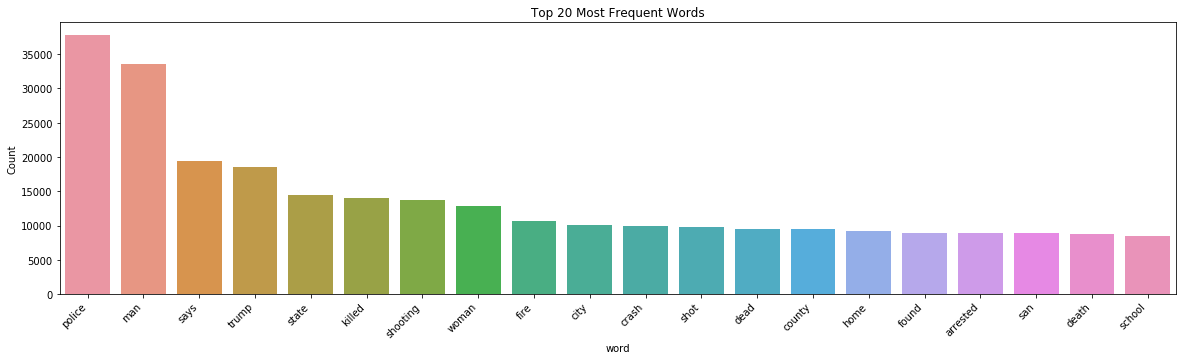

In [29]:
# Plot most frequent words
plt.figure(figsize=(20,5))
# rotate and right align group names
plt.xticks(rotation=45, ha='right')
ax = sns.barplot(data=counts, x= "word", y = "count")
ax.set(ylabel = 'Count')
ax.set(title = 'Top 20 Most Frequent Words')    
plt.show()

## Troll Amplification
Examining the troll "echo chamber". Are trolls retweeting or mentioning other trolls?

In [30]:
# read list of users created during EDA
users = pd.read_csv('../data/users_totals.csv', encoding='utf-8',low_memory=False)

userlist = users['author'].tolist()
lc_userlist = [x.lower() for x in userlist]
lc_userlist.sort()

amplify = cleaned_mentions_series[cleaned_mentions_series.isin(lc_userlist)]

print(amplify.shape[0])

# Get counts of amplified troll tweets
amp_counts = amplify.value_counts()
print("There are",(amplify.shape[0]), "trolls in the echo chamber.")

360
There are 360 trolls in the echo chamber.


### Normalization
3 distinct steps:  
* stemming  
* lemmatization  
* everything else

### Lemmatization

In [31]:
from textblob import Word
df['cleaned'] = df['cleaned'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['cleaned'].head()

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


52394    albuquerque men arrested trying sell stolen gun part
52395               albuquerque pokemon player stay give back
52396              queen elizabeth miss church due heavy cold
52397              chief urge year resolution put peace first
52398                     china say shut ivory trade end 2017
Name: cleaned, dtype: object

### Tokenize

In [32]:
#create a list from df['cleaned']
content_notags = df['cleaned'].tolist()

# First, create a new column with the tokenized text
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
#df['tokenized_text'] = df['content'].apply(tt.tokenize)
# map tt.tokenize to 'content' list
documents = list(map(tt.tokenize, content_notags))

In [33]:
from collections import defaultdict

frequency = defaultdict(int)
for document in documents:
    for token in document:
        frequency[token] += 1

In [34]:
documents = [[token for token in document if frequency[token] > 10] for document in documents]
# create a dictionary using from gensim.corpora.Dictionary
dictionary = corpora.Dictionary(documents)
#Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. 
corpus = [dictionary.doc2bow(document) for document in documents]

In [35]:
len(corpus)

598226

## LDA Model
Fit an LDA Model for the tweet topics

In [36]:
# comment out once model is trained.
# fit LDA model
tweet_topics = LdaMulticore(corpus=corpus,
                          id2word=dictionary,
                          num_topics=10,
                          passes=10,
                          workers=2)

In [37]:
# save/load model to/from disk

temp_file = datapath("model_newsfeed_tweets")
tweet_topics.save(temp_file)

# Load a pretrained model from disk.
#tweet_topics = LdaMulticore.load("model")
# - or -
#m1 = LdaMulticore.load(datapath("lda_3_0_1_model"))

In [38]:
# print out first 10 topics
for i, topic in enumerate(tweet_topics.print_topics(10)):
    print('{} --- {}'.format(i, topic))

0 --- (0, '0.065*"trump" + 0.023*"clinton" + 0.013*"donald" + 0.013*"game" + 0.012*"win" + 0.012*"ohio" + 0.009*"cleveland" + 0.009*"campaign" + 0.009*"lead" + 0.009*"sander"')
1 --- (1, '0.028*"cleveland" + 0.013*"weather" + 0.011*"weekend" + 0.011*"week" + 0.010*"storm" + 0.010*"news" + 0.009*"san" + 0.008*"monday" + 0.007*"friday" + 0.007*"area"')
2 --- (2, '0.020*"west" + 0.019*"phx" + 0.017*"east" + 0.017*"jersey" + 0.016*"philadelphia" + 0.013*"resident" + 0.010*"sun" + 0.010*"side" + 0.009*"tempe" + 0.009*"crime"')
3 --- (3, '0.019*"orleans" + 0.012*"year" + 0.009*"photo" + 0.009*"day" + 0.007*"season" + 0.007*"coach" + 0.007*"look" + 0.007*"best" + 0.007*"player" + 0.007*"star"')
4 --- (4, '0.043*"arizona" + 0.025*"court" + 0.016*"kansa" + 0.014*"judge" + 0.013*"face" + 0.013*"case" + 0.012*"trial" + 0.008*"life" + 0.008*"nashville" + 0.007*"story"')
5 --- (5, '0.031*"school" + 0.030*"fire" + 0.029*"phoenix" + 0.020*"crash" + 0.011*"high" + 0.010*"student" + 0.009*"louisiana" +

### Wordcloud
Crate a basic word cloud of the topic groupings

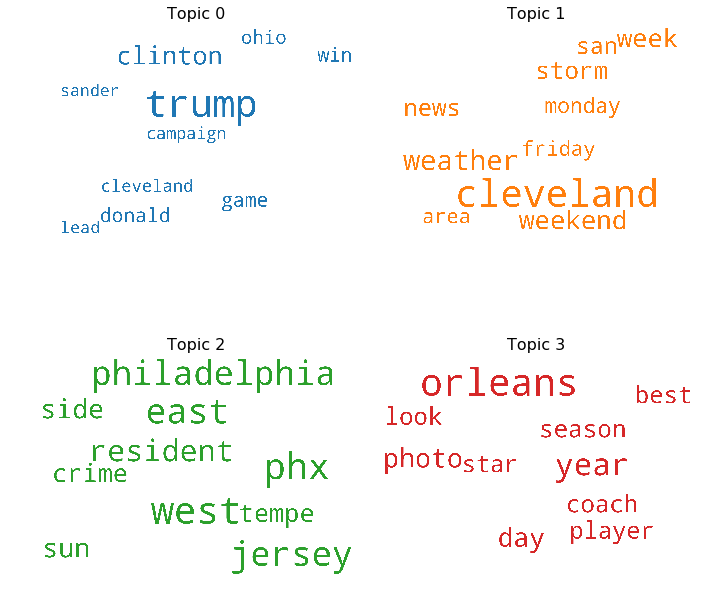

In [39]:
#Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = tweet_topics.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Use pyLDAvis library to Visualize Topics

In [40]:
## Try the pyLDAvis visualization
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [41]:
# http://tlfvincent.github.io/2015/10/23/presidential-speech-topics/#topic=1&lambda=1&term=
vis_data = gensimvis.prepare(tweet_topics, corpus, dictionary)
pyLDAvis.display(vis_data)

/Users/admin/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Output Visualization Tool to HTML

In [42]:
# save viz output to an HTML file
vis_data = gensimvis.prepare(tweet_topics, corpus, dictionary)

pyLDAvis.save_html(vis_data, 'pyLDAviz_newsfeed.html')

### Next, examine the hashtags and topics of each troll group
Analyze the hashtags, mentions, and topics of each of the seven "troll classes", as defined by Clemson University's Darren Linvill and Patrick Warren in their analysis of the Russian Troll Farm Twitter data.